# PA3b Sentiment Classification
#### Applied Machine Learning
Grpup 39: Sebastian Kölbel & Min Ze Teh

We begin by importing libraries needed for the task

In [201]:
!pip install seaborn

In [202]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# for converting training and test datasets into matrices
from sklearn.feature_extraction.text import TfidfVectorizer

Now to begin handling the annotations based on classification of tweets as positive, negative or neutral we began by creating a function for preprocessing the csv-files. These preprocessing steps include:
* Making text all lower case
* Removing leading and closing white-space
* Importing the csv data into pandas dataframes

We skipped removing punctuations as they are removed when used with TfidfVectorizer in a later step.

In [203]:
# requres a CSV file containing two columns of tab delimited data, where the first column is the sentiment and the second is the evaluated text
def read_sentiments(doc_file):
    with open(doc_file, 'r', encoding='utf-8') as f:
        new_lines = []
        for line in f:
            line = line.lower().removesuffix('\n').strip()
            new_lines.append(line.split('\t'))
                
        return pd.DataFrame(new_lines,columns=['sentiment','text']).drop(0)

We then separate the input values from the output values. The crowdsourced data needed some more preprocessing. There we too many values for the sentiments all consisting of typos. We checked how many errors there were, however there were only 75 errors out of more than 10 000 rows so the errors were dropped to save time.

In [204]:
df = read_sentiments('Data/crowdsourced_train.csv')
cs_training = df[df['sentiment'].isin(['positive','negative','neutral'])]
print('Dropped rows in crowdsourced data:',len(df)-len(cs_training))
X_cs_train = cs_training.drop('sentiment', axis=1)
Y_cs_train = cs_training['sentiment']

gold_training = read_sentiments('Data/gold_train.csv')
X_gold_train = gold_training.drop('sentiment', axis=1)
Y_gold_train = gold_training['sentiment']


testing = read_sentiments('Data/test.csv')
X_test = testing.drop('sentiment', axis=1)
Y_test = testing['sentiment']

Dropped rows in crowdsourced data: 75


Since there are double annotations for the texts, from crowdsource as well as from the 'gold' source. We compared the annotations for each text, this was done using the cohen_kappa_score which calculates a score based on how well the both annotations match. We also checked to see what ratio of every evaluation there was for each annotation source. The results showed that for the crowdsourced data, sentiments leaned more towards the negtive while on the gold anotations there were more both positive and negative evaluations for the tweets.

In [205]:
from sklearn.metrics import cohen_kappa_score

# compare crowdsourced vs gold labeling
print(Y_cs_train.value_counts(normalize=True))
print(Y_gold_train.value_counts(normalize=True))
print('\nCohen kappa score: ', cohen_kappa_score(df['sentiment'], Y_gold_train, labels=['negative','positive','neutral']))

sentiment
neutral     0.473257
positive    0.302990
negative    0.223752
Name: proportion, dtype: float64
sentiment
neutral     0.502435
positive    0.342076
negative    0.155489
Name: proportion, dtype: float64

Cohen kappa score:  0.44643812445708253


The next step is creating a model for classification. We attempted a couple different methods, such as LinearSVC and Logistic Regression. Both methods had a vectorizer step before, using the TfidfVectorizer. We performed a grid search to evaluate different parameters and selected the best performing ones. 

Using Tfidf vectorizer and LinearSVC

In [206]:
def train_document_classifier(X, Y):
    # Define the pipeline with TfidfVectorizer and LinearSVC
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LinearSVC(dual='auto',random_state=0))
    ])
    
    # Define the parameter grid
    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams or bigrams      
        'tfidf__max_features': [1000, 5000, 10000],  # Maximum number of features
        'clf__C': [0.1, 1, 10]  # Regularization parameter
    }
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X, Y)
    
    # Return the best trained pipeline
    return grid_search.best_estimator_


In [207]:
# Convert the DataFrame column containing text data into a list of strings
X_cs_train_text = X_cs_train['text']

# Now X_cs_train_text is a list of strings representing the text data for each document
# Train the pipeline
pipeline = train_document_classifier(X_cs_train_text, Y_cs_train)
print('Used parameters:', pipeline.steps)

X_test_text = X_test['text']

# Test the trained pipeline
Y_pred = pipeline.predict(X_test_text)

# Evaluate the performance
print(classification_report(Y_test, Y_pred))

Used parameters: [('tfidf', TfidfVectorizer(max_features=10000)), ('clf', LinearSVC(C=0.1, dual='auto', random_state=0))]
              precision    recall  f1-score   support

    negative       0.58      0.40      0.47      1077
     neutral       0.59      0.82      0.69      2597
    positive       0.73      0.47      0.57      1850

    accuracy                           0.62      5524
   macro avg       0.64      0.56      0.58      5524
weighted avg       0.64      0.62      0.61      5524



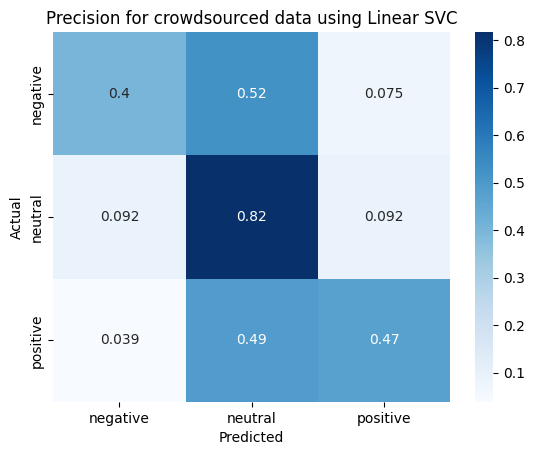

In [208]:
matrix = confusion_matrix(Y_test, Y_pred, normalize="true")

sns.heatmap(matrix, cmap='Blues', annot=True, xticklabels=['negative', 'neutral','positive'], yticklabels=['negative', 'neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Precision for crowdsourced data using Linear SVC')
plt.show()

In [209]:
# Convert the DataFrame column containing text data into a list of strings
X_gold_train_text = X_gold_train['text']

# Now X_gold_train_text is a list of strings representing the text data for each document
# Train the pipeline
pipeline = train_document_classifier(X_gold_train_text, Y_gold_train)
print('Used parameters:', pipeline.steps)

X_test_text = X_test['text']

# Test the trained pipeline
Y_pred = pipeline.predict(X_test_text)

# Evaluate the performance
print(classification_report(Y_test, Y_pred))


Used parameters: [('tfidf', TfidfVectorizer(max_features=5000)), ('clf', LinearSVC(C=0.1, dual='auto', random_state=0))]
              precision    recall  f1-score   support

    negative       0.77      0.29      0.42      1077
     neutral       0.62      0.86      0.72      2597
    positive       0.74      0.61      0.67      1850

    accuracy                           0.67      5524
   macro avg       0.71      0.59      0.60      5524
weighted avg       0.69      0.67      0.65      5524



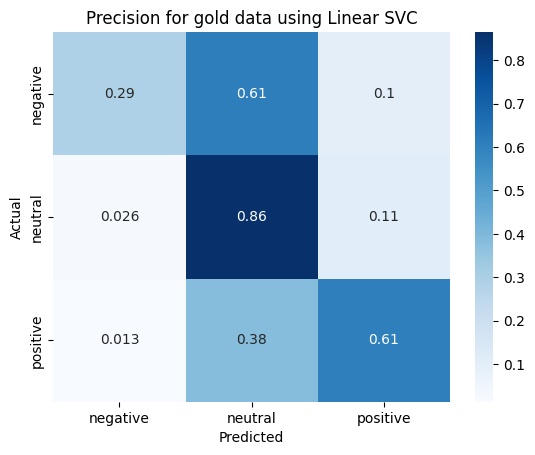

In [210]:
matrix = confusion_matrix(Y_test, Y_pred, normalize="true")

sns.heatmap(matrix, cmap='Blues', annot=True, xticklabels=['negative', 'neutral','positive'], yticklabels=['negative', 'neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Precision for gold data using Linear SVC')
plt.show()

Using Tfidf vectorizer and Logistic Regression

In [211]:
def train_document_classifier_log_reg(X, Y):
    # Define the pipeline with TfidfVectorizer and LogisticRegression
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ])
    
    # Define the parameter grid
    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams or bigrams
        'tfidf__max_features': [1000, 5000, 10000],  # Maximum number of features
        'clf__C': [0.1, 1, 10],  # Regularization parameter
        'clf__max_iter': [100,500,1000]  # Maximum number of iterations
    }
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X, Y)
    
    # Return the best trained pipeline
    return grid_search.best_estimator_


In [212]:
# Convert the DataFrame column containing text data into a list of strings
X_cs_train_text = X_cs_train['text'].tolist()

# Now X_cs_train_text is a list of strings representing the text data for each document
# Train the pipeline
pipeline = train_document_classifier_log_reg(X_cs_train_text, Y_cs_train)
print('Used parameters:', pipeline.steps)

X_test_text = X_test['text'].tolist()

# Test the trained pipeline
Y_pred = pipeline.predict(X_test_text)

# Evaluate the performance
print(classification_report(Y_test, Y_pred))


/home/koelbel/aml/my_project_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/koelbel/aml/my_project_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Used parameters: [('tfidf', TfidfVectorizer(max_features=5000)), ('clf', LogisticRegression(C=1))]
              precision    recall  f1-score   support

    negative       0.56      0.47      0.51      1077
     neutral       0.60      0.77      0.68      2597
    positive       0.72      0.49      0.58      1850

    accuracy                           0.62      5524
   macro avg       0.62      0.58      0.59      5524
weighted avg       0.63      0.62      0.61      5524



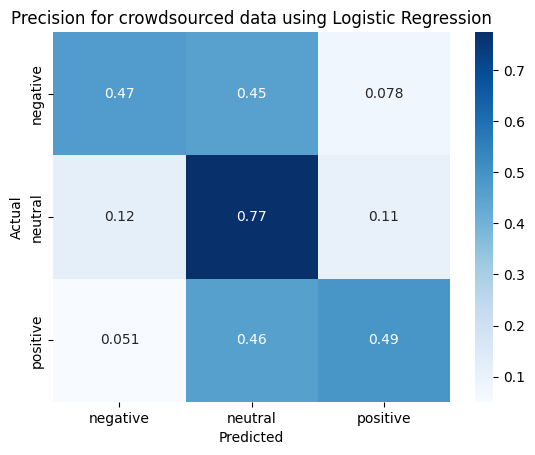

In [213]:
matrix = confusion_matrix(Y_test, Y_pred, normalize="true")

sns.heatmap(matrix, cmap='Blues', annot=True, xticklabels=['negative', 'neutral','positive'], yticklabels=['negative', 'neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Precision for crowdsourced data using Logistic Regression')
plt.show()

In [214]:
# Convert the DataFrame column containing text data into a list of strings
X_gold_train_text = X_gold_train['text'].tolist()

# Now X_gold_train_text is a list of strings representing the text data for each document
# Train the pipeline
pipeline = train_document_classifier_log_reg(X_gold_train_text, Y_gold_train)
print('Used parameters:', pipeline.steps)

X_test_text = X_test['text'].tolist()

# Test the trained pipeline
Y_pred = pipeline.predict(X_test_text)

# Evaluate the performance
print(classification_report(Y_test, Y_pred))


/home/koelbel/aml/my_project_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/koelbel/aml/my_project_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Used parameters: [('tfidf', TfidfVectorizer(max_features=5000)), ('clf', LogisticRegression(C=1))]
              precision    recall  f1-score   support

    negative       0.73      0.39      0.51      1077
     neutral       0.65      0.84      0.73      2597
    positive       0.75      0.65      0.69      1850

    accuracy                           0.69      5524
   macro avg       0.71      0.63      0.65      5524
weighted avg       0.70      0.69      0.68      5524



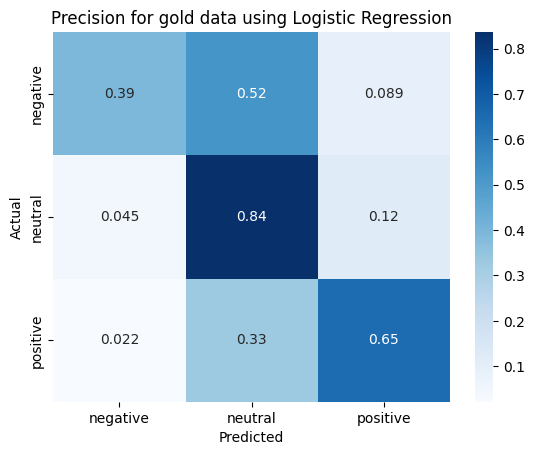

In [215]:
matrix = confusion_matrix(Y_test, Y_pred, normalize="true")

sns.heatmap(matrix, cmap='Blues', annot=True, xticklabels=['negative', 'neutral','positive'], yticklabels=['negative', 'neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Precision for gold data using Logistic Regression')
plt.show()